In [ ]:
import os
image_folder_path = '/content/drive/MyDrive/Acne'
image_paths = [os.path.join(image_folder_path, fname) for fname in os.listdir(image_folder_path)]
print(f"Found {len(image_paths)} images.")

Found 639 images.


In [ ]:
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0  # Normalize
    return img

In [ ]:
processed_images = np.array([preprocess_image(img_path) for img_path in image_paths])

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = resnet_model.predict(img_data)
    return features

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
image_features = np.array([extract_features(img) for img in image_paths])
image_features = image_features.reshape(len(image_features), -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
pca = PCA(n_components=50)# Reduce to 50 dimensions
reduced_features = pca.fit_transform(image_features)
print(f"Reduced features shape: {reduced_features.shape}")

Reduced features shape: (639, 50)


In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(reduced_features)
cluster_labels = kmeans.labels_
print(f"Cluster distribution: {Counter(cluster_labels)}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster distribution: Counter({4: 194, 1: 142, 0: 135, 3: 116, 2: 52})


In [ ]:
# Calculate redness (intensity in red channel) and texture (LBP)
def calculate_redness(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    red_channel = hsv[:, :, 0]  # Red channel
    redness = np.mean(red_channel)
    return redness

def calculate_texture(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, method="uniform")
    texture_score = lbp.mean()
    return texture_score

redness_scores = [calculate_redness(img) for img in image_paths]
texture_scores = [calculate_texture(img) for img in image_paths]

# Normalize the scores to a scale of 0 to 1
redness_scores = np.array(redness_scores) / np.max(redness_scores)
texture_scores = np.array(texture_scores) / np.max(texture_scores)

# Combine redness and texture scores into a single severity score
severity_scores = 0.7 * redness_scores + 0.3 * texture_scores

In [ ]:
def assign_severity(cluster_label, score):
    if cluster_label == 0:
        return 0  # Near perfect
    elif cluster_label == 1:
        if score < 0.5:
            return 1  # Almost clear
        else:
            return 2  # Mild
    elif cluster_label == 2:
        if score < 0.5:
            return 2  # Mild
        else:
            return 3  # Moderate
    elif cluster_label == 3:
        if score < 0.5:
            return 3  # Moderate
        else:
            return 4  # Severe
    elif cluster_label == 4:
        return 4  # Cluster 4 -> Severity 4 (severe)
automated_severity_labels = [assign_severity(cluster, score) for cluster, score in zip(cluster_labels, severity_scores)]
for img_path, severity in zip(image_paths, automated_severity_labels):
    print(f"Image: {img_path} -> Assigned Severity: {severity}")

Image: /content/drive/MyDrive/Acne/07Acne0811011 - Copy.jpg -> Assigned Severity: 1
Image: /content/drive/MyDrive/Acne/07RosaceaFulFAce1 - Copy.jpg -> Assigned Severity: 0
Image: /content/drive/MyDrive/Acne/07Acne0811011.jpg -> Assigned Severity: 1
Image: /content/drive/MyDrive/Acne/07RosaceaFulFAce.jpg -> Assigned Severity: 0
Image: /content/drive/MyDrive/Acne/07Acne081101.jpg -> Assigned Severity: 1
Image: /content/drive/MyDrive/Acne/18.jpg -> Assigned Severity: 4
Image: /content/drive/MyDrive/Acne/07RosaceaOK08280631.jpg -> Assigned Severity: 1
Image: /content/drive/MyDrive/Acne/0_before.jpg -> Assigned Severity: 4
Image: /content/drive/MyDrive/Acne/17a4d1a917e5faa9f2675ebd83e52679.jpg -> Assigned Severity: 4
Image: /content/drive/MyDrive/Acne/10_Skin1.jpg -> Assigned Severity: 4
Image: /content/drive/MyDrive/Acne/11.jpg -> Assigned Severity: 4
Image: /content/drive/MyDrive/Acne/14.jpg -> Assigned Severity: 0
Image: /content/drive/MyDrive/Acne/13.jpg -> Assigned Severity: 4
Image: /

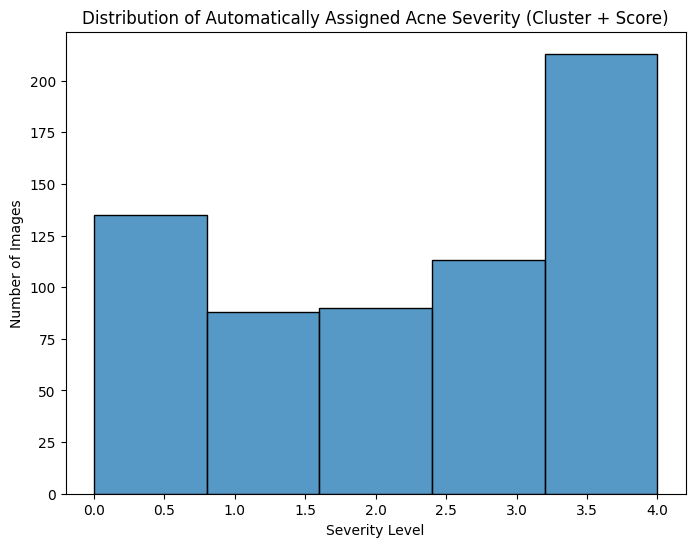

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(automated_severity_labels, bins=5, kde=False)
plt.title("Distribution of Automatically Assigned Acne Severity (Cluster + Score)")
plt.xlabel("Severity Level")
plt.ylabel("Number of Images")
plt.show()

Displaying images labeled as severity 0:


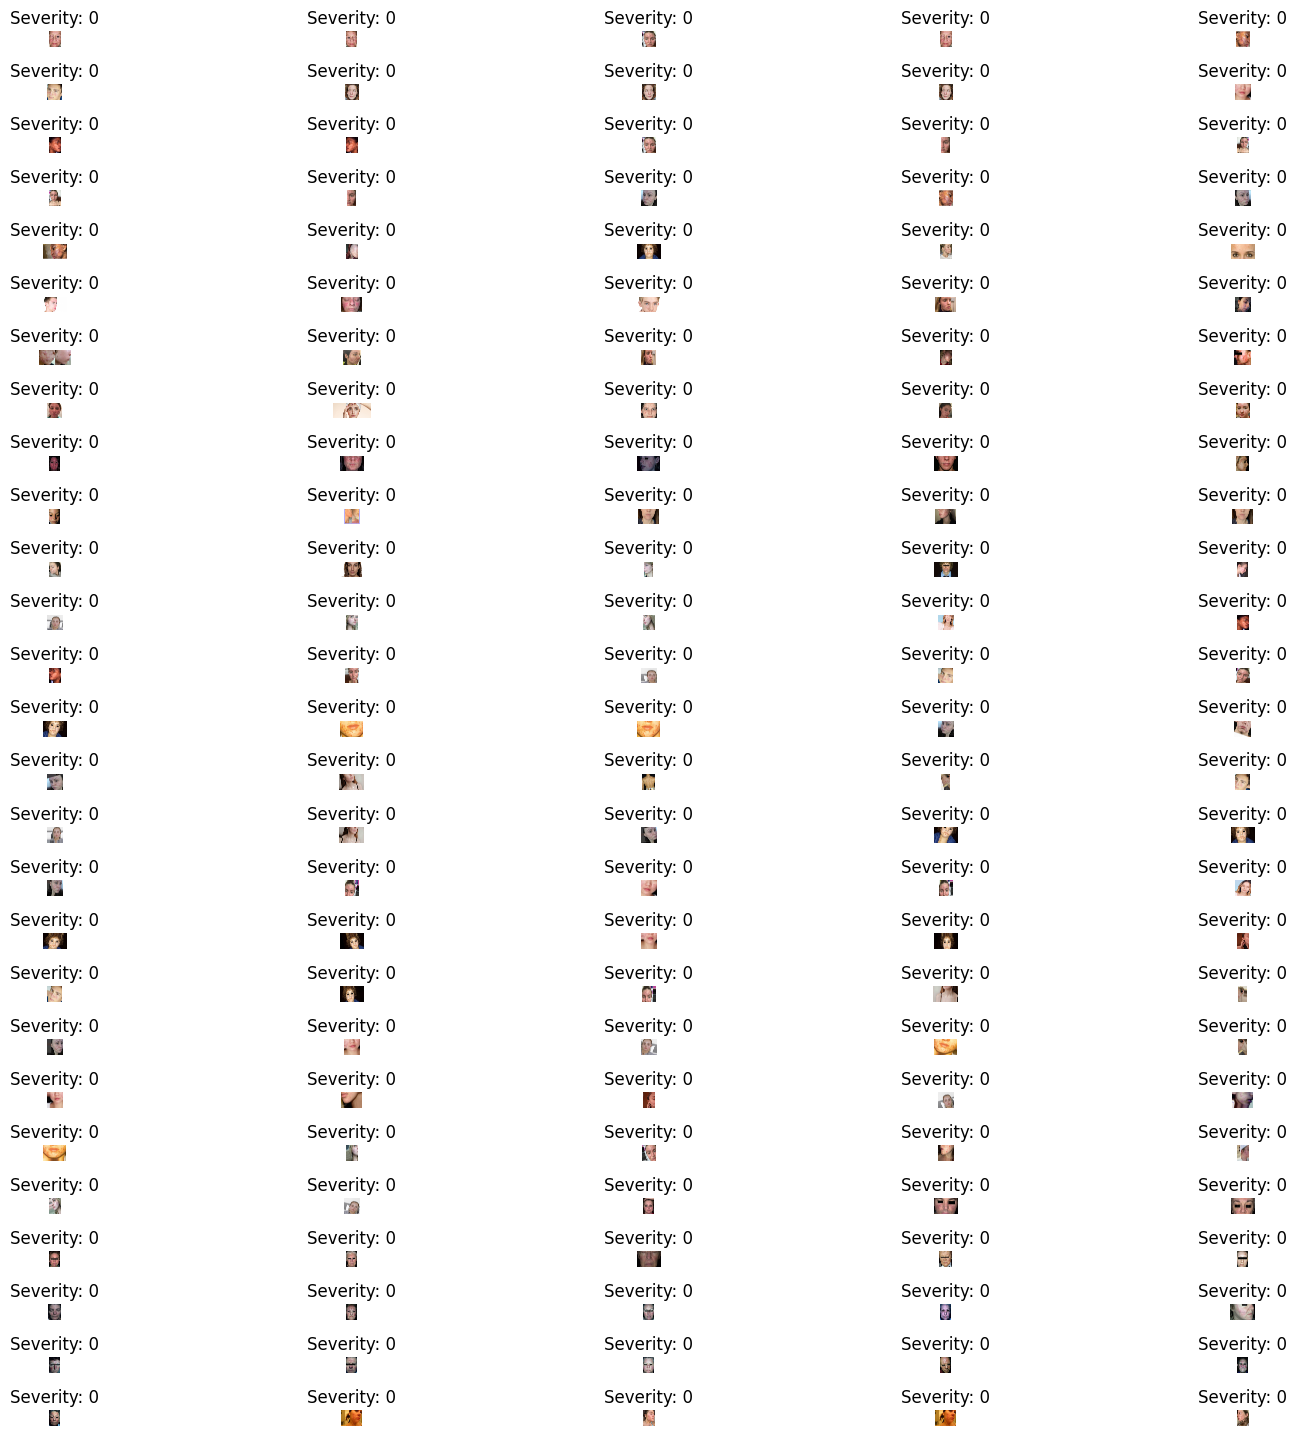

Displaying images labeled as severity 1:


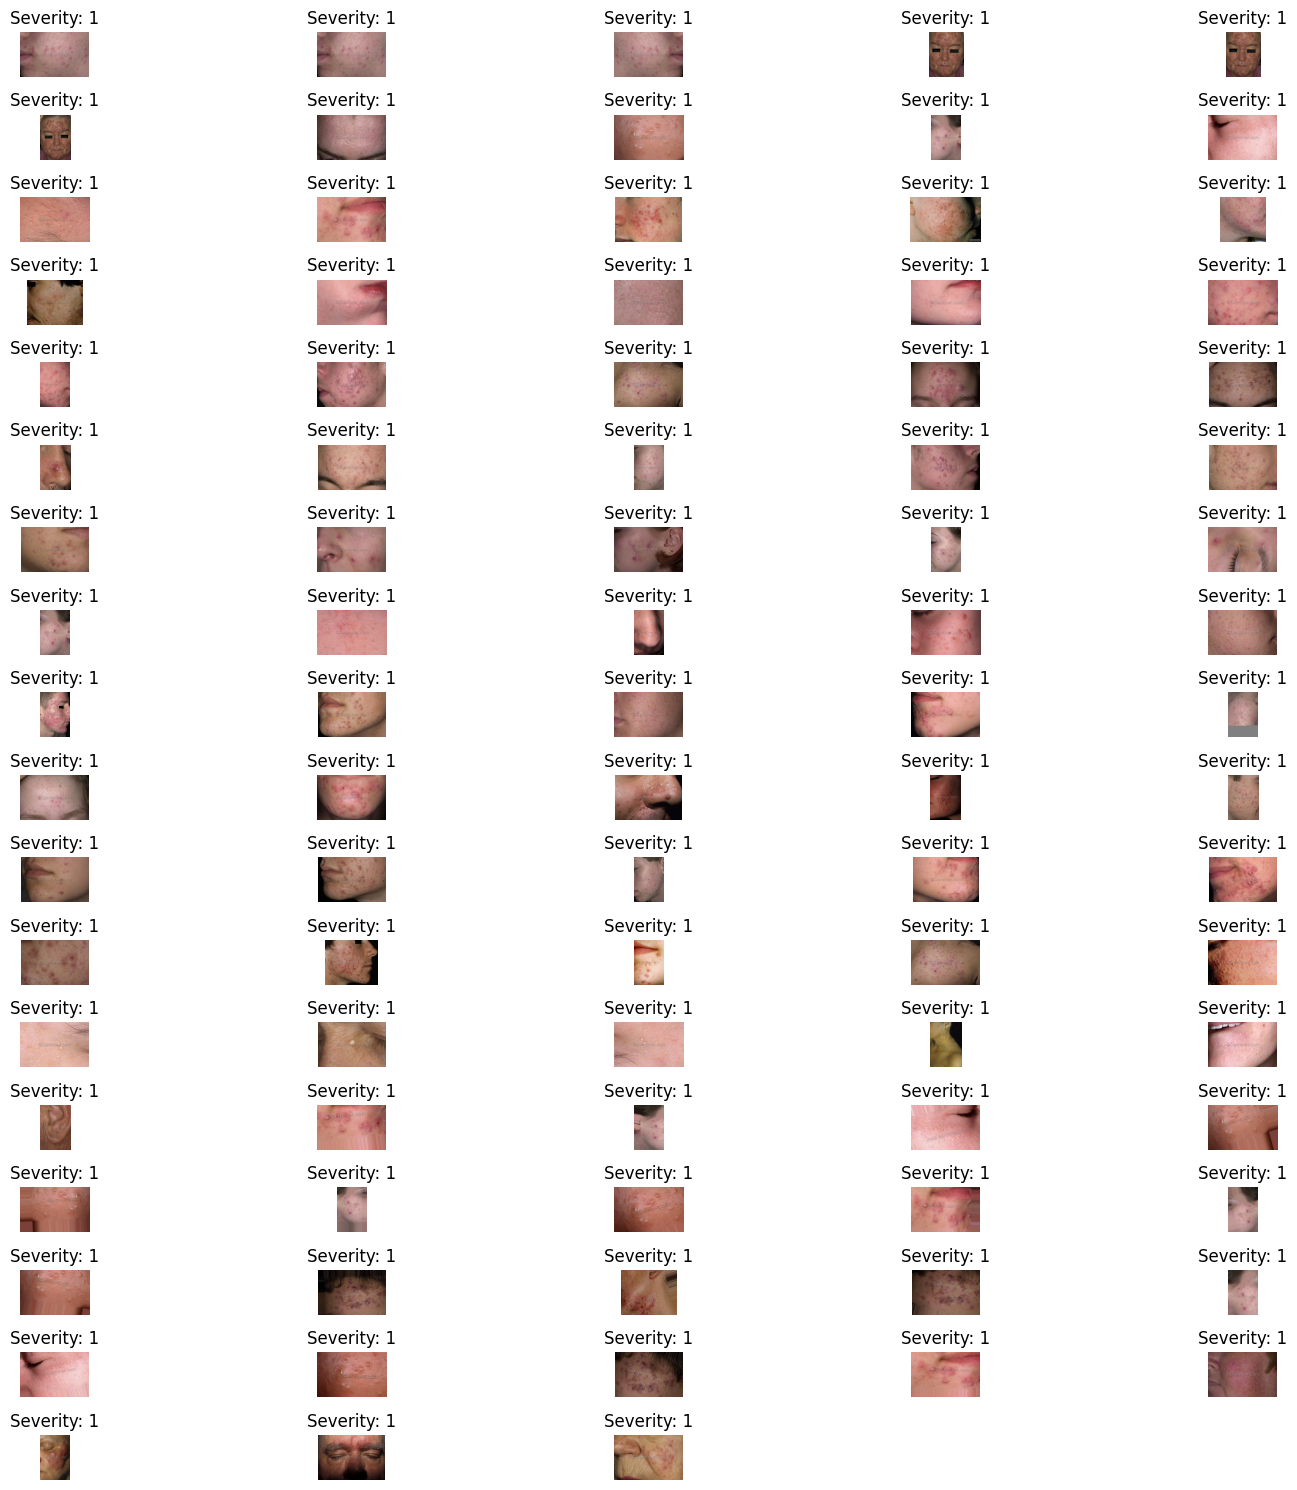

Displaying images labeled as severity 2:


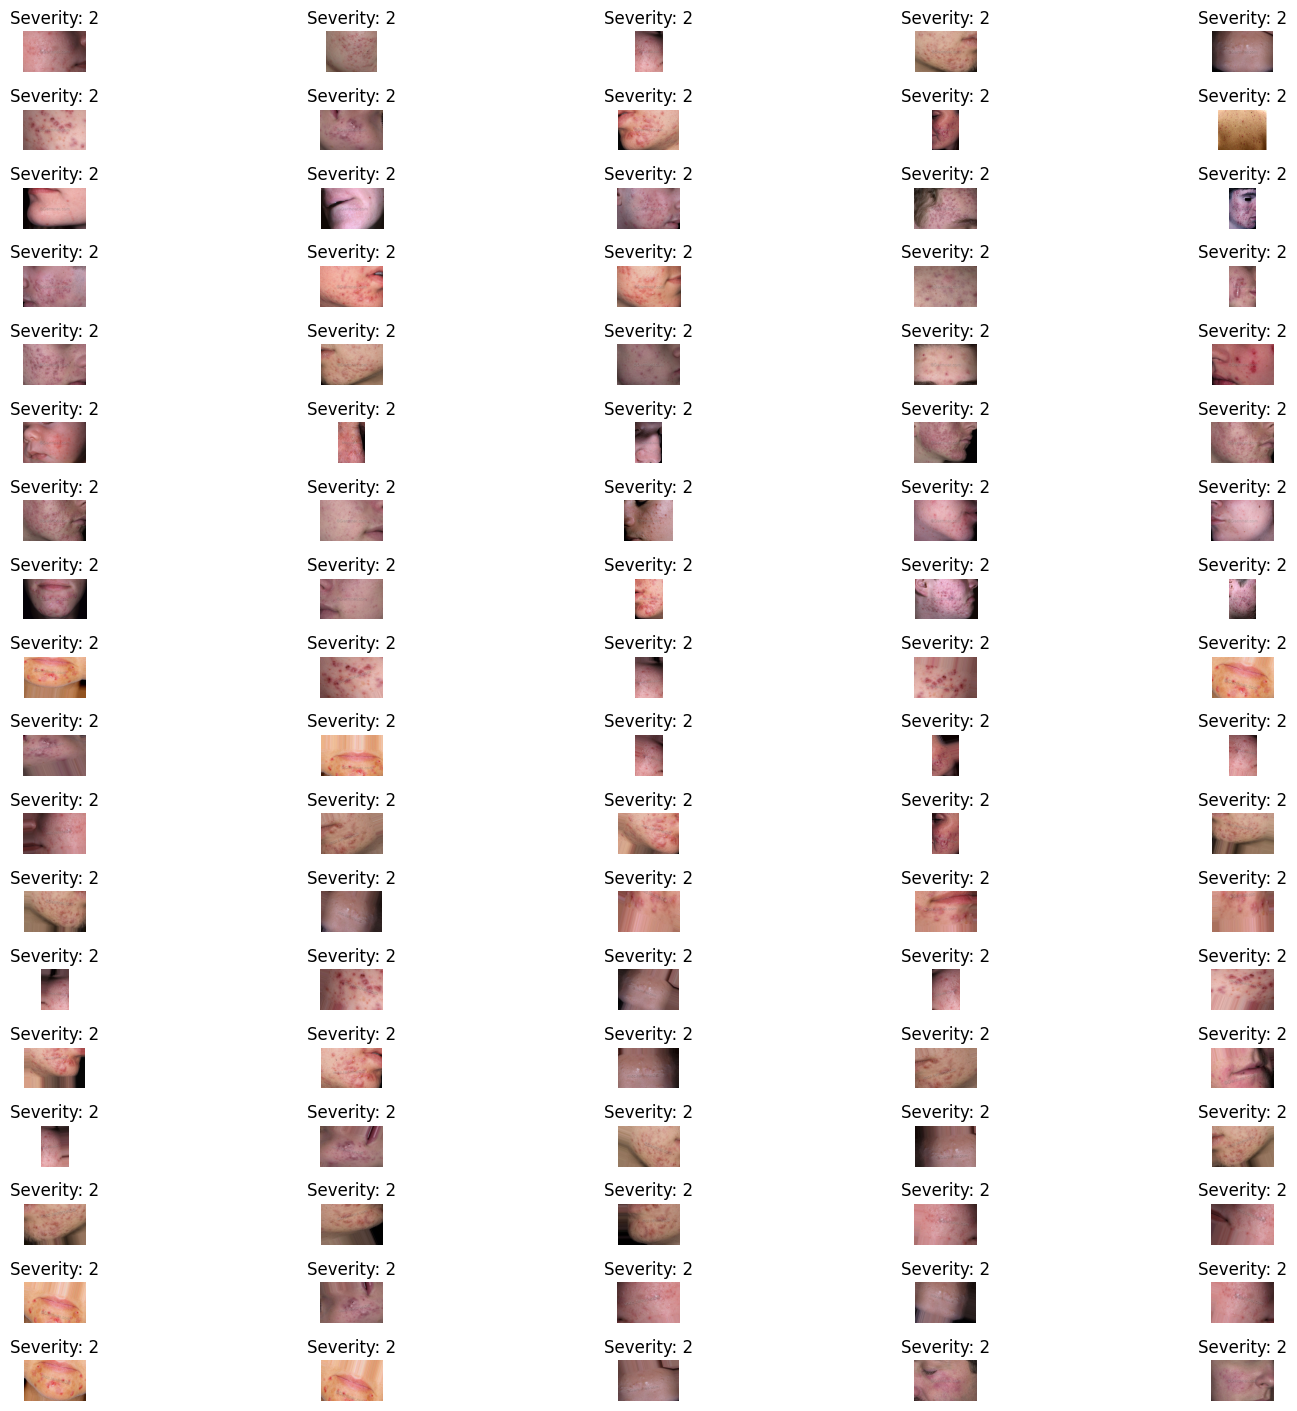

Displaying images labeled as severity 3:


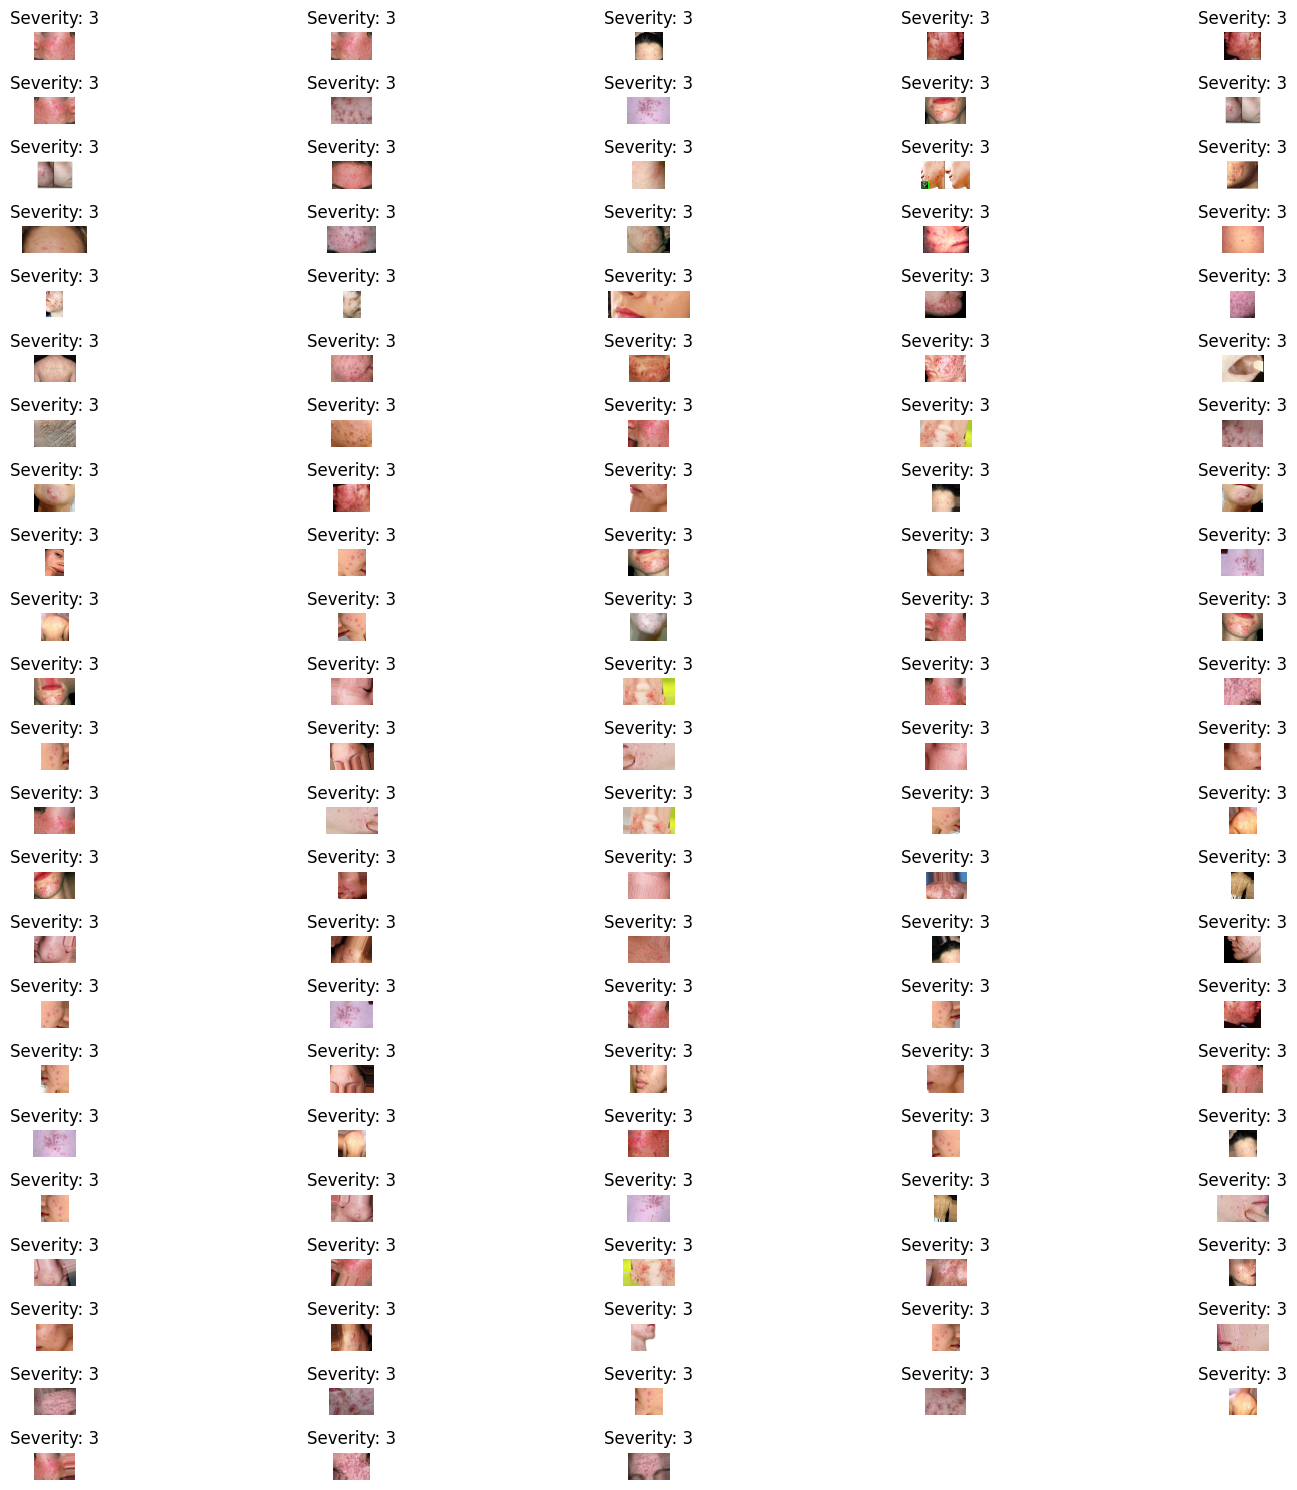

Displaying images labeled as severity 4:


<ipython-input-12-9d8504d48f19>:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


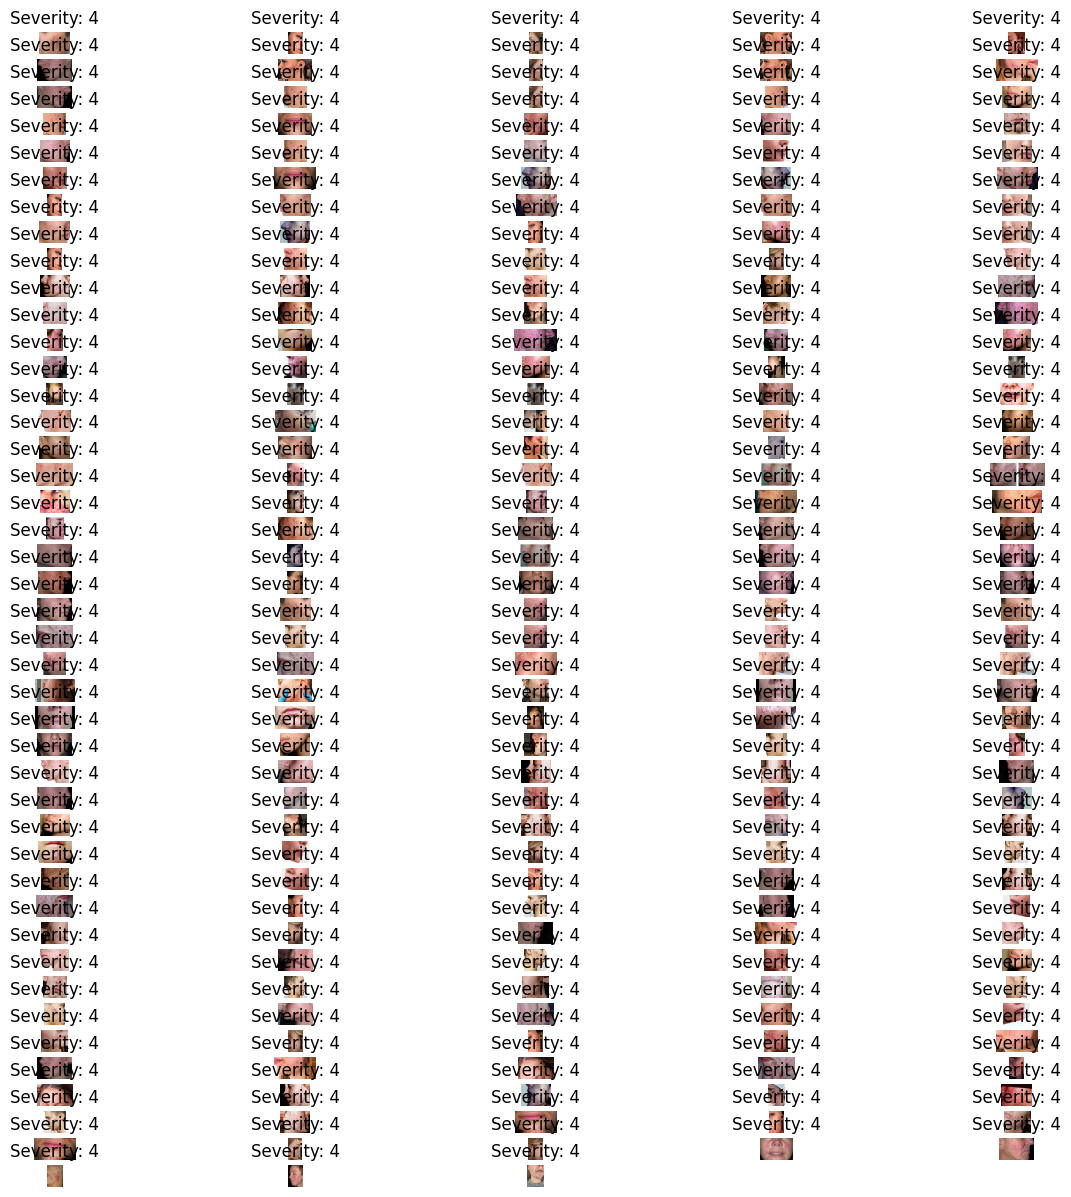

In [ ]:
def display_images_with_labels(image_paths, labels, num_images_per_row=5):
    unique_labels = sorted(set(labels))  # Get unique severity labels (0, 1, 2, 3, 4)

    for severity in unique_labels:
        print(f"Displaying images labeled as severity {severity}:")
        severity_indices = [i for i, label in enumerate(labels) if label == severity]
        # Plot the images with the current severity label
        num_images = len(severity_indices)
        rows = (num_images // num_images_per_row) + 1  # Calculate the number of rows needed
        plt.figure(figsize=(15, 15))
        for i in range(num_images):
            if i >= num_images_per_row * rows:
                break  # Stop if we've displayed enough images

            img_idx = severity_indices[i]
            img = cv2.imread(image_paths[img_idx])  # Load the image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

            plt.subplot(rows, num_images_per_row, i + 1)
            plt.imshow(img)
            plt.title(f"Severity: {severity}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Call the function to display images with their severity labels
display_images_with_labels(image_paths, automated_severity_labels)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.2293 - loss: 1.7038 - val_accuracy: 0.1754 - val_loss: 1.7679
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.2727 - loss: 1.6563 - val_accuracy: 0.3333 - val_loss: 1.5439
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.3225 - loss: 1.5349 - val_accuracy: 0.3333 - val_loss: 1.6139
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.3423 - loss: 1.5393 - val_accuracy: 0.3333 - val_loss: 1.5188
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.3173 - loss: 1.5439 - val_accuracy: 0.3333 - val_loss: 1.5730
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.4190 - loss: 1.4477 - val_accuracy: 0.2982 - val_loss: 1.5829
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.4217 - loss: 1.4645 - val_accuracy: 0.2982 - val_loss: 1.5197
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.4210 - loss: 1.4522 - val_accuracy: 0.1754 - val_loss:

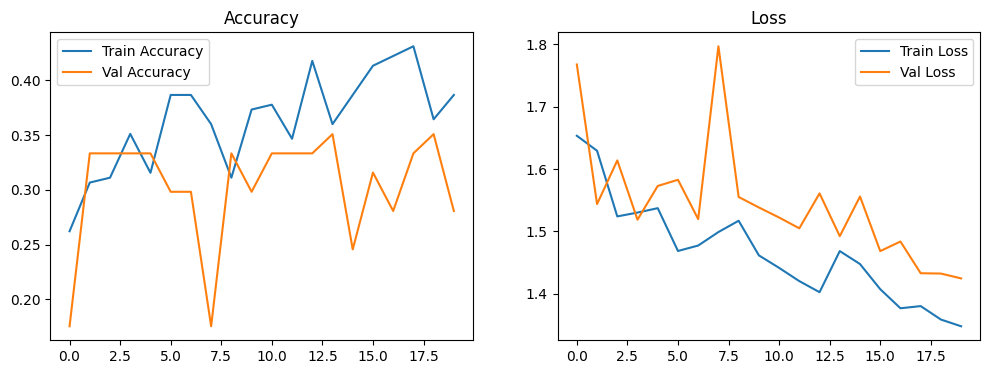

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 7: CNN Model Definition and Training

# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    processed_images, automated_severity_labels, test_size=0.2, random_state=42)

# Convert labels to numpy array for compatibility with Keras
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Option 1: Using a simple CNN from scratch
def build_simple_cnn(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # For 5 severity levels (0-4)
    ])
    return model

# Option 2: Using a pre-trained model (e.g., ResNet50) for transfer learning
def build_transfer_learning_model(input_shape=(224, 224, 3), num_classes=5):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build model (Choose either simple CNN or transfer learning model)
model = build_transfer_learning_model()

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary

# Train the model
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels),
                    epochs=20, batch_size=16)

# Step 8: Save the trained model
model.save('acne_severity_model.h5')

# Step 9: Visualize Training History

# Function to plot accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

# Plot the training history
plot_training_history(history)


Training ResNet50 model...
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.3587 - loss: 1.5790 - val_accuracy: 0.4531 - val_loss: 1.4239
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.4365 - loss: 1.4568 - val_accuracy: 0.4531 - val_loss: 1.4285
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.4279 - loss: 1.4246 - val_accuracy: 0.4531 - val_loss: 1.3486
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.4828 - loss: 1.3421 - val_accuracy: 0.4766 - val_loss: 1.3375
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.5134 - loss: 1.3336 - val_accuracy: 0.4531 - val_loss: 1.4877
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.4188 - loss: 1.4267 - val_accuracy: 0.5781 - val_loss: 1.2309
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.4930 - loss: 1.2086 - val_accuracy: 0.5078 - val_loss: 1.1905
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.4915 - loss: 1.2099

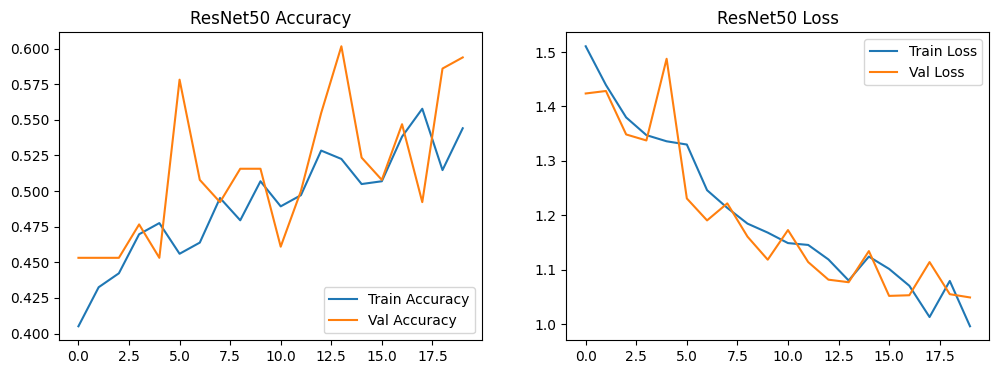

Evaluating ResNet50 model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        58
           1       0.33      0.22      0.27        18
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        16
           4       0.40      0.90      0.55        20

    accuracy                           0.59       128
   macro avg       0.30      0.41      0.33       128
weighted avg       0.45      0.59      0.50       128

Training VGG16 model...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


ValueError: Unknown variable: <KerasVariable shape=(512, 256), dtype=float32, path=sequential_1/dense_3/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Split data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    processed_images, automated_severity_labels, test_size=0.2, random_state=42)

# Convert labels to numpy array for compatibility with Keras
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Function to build models using transfer learning
def build_transfer_learning_model(base_model, input_shape=(224, 224, 3), num_classes=5):
    base_model = base_model(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile and train different models for comparison
def compile_and_train(model, optimizer=Adam(), epochs=20, batch_size=16):
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels),
                        epochs=epochs, batch_size=batch_size)
    return history

# Evaluate the model using precision, recall, and F1-score
def evaluate_model(model):
    val_predictions = model.predict(val_images)
    val_predictions = val_predictions.argmax(axis=-1)
    print(classification_report(val_labels, val_predictions, target_names=['0', '1', '2', '3', '4']))

# Function to plot accuracy and loss
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title(f'{model_name} Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title(f'{model_name} Loss')
    plt.show()

# Build and evaluate models
models = {
    'ResNet50': ResNet50,
    'VGG16': VGG16,
    'EfficientNetB0': EfficientNetB0
}

for model_name, model_fn in models.items():
    print(f"Training {model_name} model...")
    model = build_transfer_learning_model(model_fn)
    history = compile_and_train(model)
    plot_training_history(history, model_name)
    print(f"Evaluating {model_name} model...")
    evaluate_model(model)
